In [108]:
import numpy as np
import pickle
import glob
from astropy.io import fits
import filfind_class as filfind
from cube_fil_finder.vis import tree_vis
from cube_fil_finder.util import tree_dict_util
from cube_fil_finder.util import moments
from cube_fil_finder.galfa import galfa_const
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

Optional package aplpy could not be imported.


In [123]:
reload(tree_dict_util)
reload(tree_vis)
reload(moments)

<module 'cube_fil_finder.util.moments' from '/Users/larryli/Documents/CC/16-17/research/3d_filfind/cube_fil_finder/util/moments.pyc'>

In [3]:
third_batch_all_pickle = '../pickled_dicts/third_batch/all_trees.p'
third_batch_all = pickle.load(open(third_batch_all_pickle, 'rb'))

In [19]:
print('{0} trees found in the third batch'.format(len(third_batch_all)))

22900 trees found in the third batch


In [22]:
roundness_all = tree_dict_util.get_mask_roundness_dist(third_batch_all)

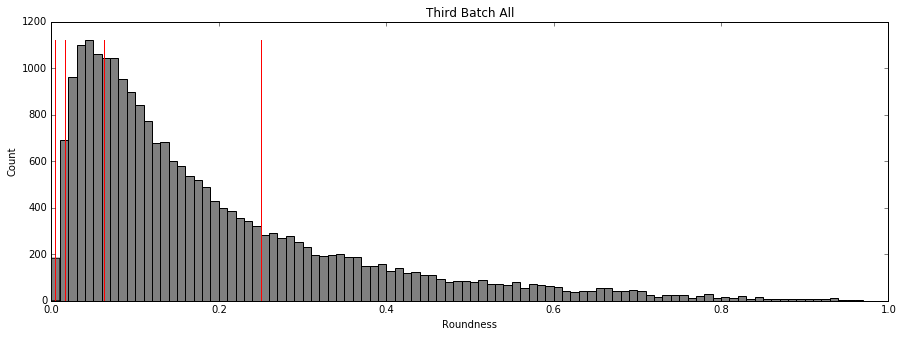

In [59]:
fig1 = tree_vis.vis_roundness_histogram(roundness_all, 'Third Batch All', return_fig=True)
fig1.show()

In [70]:
selected_trees_area_length = {}
size_thresh = 5000
length_thresh = 2
for k in third_batch_all:
    this_tree = third_batch_all[k]
    if this_tree.getTreeMaskedArea2D() > size_thresh and this_tree.length > length_thresh:
        selected_trees_area_length[k] = third_batch_all[k]

In [71]:
print('{0} trees selected after applying length & size threshold'.format(len(selected_trees_area_length)))

1846 trees selected after applying length & size threshold


In [72]:
roundness_select = tree_dict_util.get_mask_roundness_dist(selected_trees_area_length)

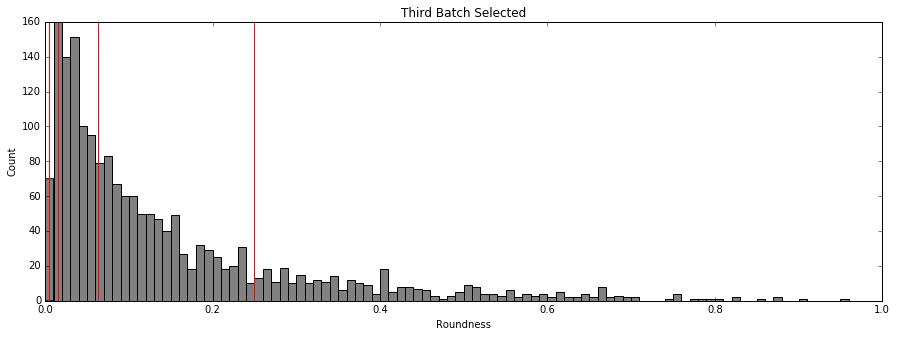

In [73]:
fig2 = tree_vis.vis_roundness_histogram(roundness_select, 'Third Batch Selected', return_fig=True)
fig2.show()

In [82]:
print('{0} trees with AR < 1:6 and {1} trees with AR <1:8'
      .format(len(np.where(roundness_select < moments.ROUNDNESS_AR_CONVERSION['1_6'])[0]),
              len(np.where(roundness_select < moments.ROUNDNESS_AR_CONVERSION['1_8'])[0])))

338 trees with AR < 1:6 and 158 trees with AR <1:8


### 1:6 and 1:8 cuts

In [83]:
third_batch_1_6 = {}
third_batch_1_8 = {}
for k in selected_trees_area_length:
    roundness = moments.get_tree_mask_orientation_info(selected_trees_area_length[k])[4]
    if roundness <= moments.ROUNDNESS_AR_CONVERSION['1_6']:
        third_batch_1_6[k] = selected_trees_area_length[k]
    if roundness <= moments.ROUNDNESS_AR_CONVERSION['1_8']:
        third_batch_1_8[k] = selected_trees_area_length[k]

In [112]:
third_batch_1_6_pickle = '../pickled_dicts/third_batch/all_trees_1_6.p'
third_batch_all = pickle.dump(third_batch_1_6, open(third_batch_1_6_pickle, 'wb'))

third_batch_1_8_pickle = '../pickled_dicts/third_batch/all_trees_1_8.p'
third_batch_all = pickle.dump(third_batch_1_8, open(third_batch_1_8_pickle, 'wb'))

In [96]:
for k in third_batch_1_6:
    save_dropbox = '/Users/larryli/Dropbox/GALFA_filfind_yes_no_maybe/third_batch/third_batch_1_6/'
    this_node = third_batch_1_6[k]
    tree_vis.vis_mask_tree_moment(this_node, k, save_fig=True, save_dir=save_dropbox)

/Users/larryli/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [97]:
for k in third_batch_1_8:
    save_dropbox = '/Users/larryli/Dropbox/GALFA_filfind_yes_no_maybe/third_batch/third_batch_1_8/'
    this_node = third_batch_1_8[k]
    tree_vis.vis_mask_tree_moment(this_node, k, save_fig=True, save_dir=save_dropbox)

In [99]:
def create_0th_moment_map(cube):
    moment_map = np.zeros_like(cube[0])
    for s in cube:
        moment_map = np.add(moment_map, s)
    
    return moment_map

In [100]:
DATA_SLICE_BASE_DIR = '/Volumes/LarryExternal1/Research_2017/GALFA_slices_backup/umask_gaussian_30/'

In [109]:
widths_fits_1_6 = {} # 1_8 is a subset of 1_6

for key in third_batch_1_6:
    this_node = third_batch_1_6[key]
    slice_files_list = []
    for i in range(this_node.length):
        slice_file_name = glob.glob(DATA_SLICE_BASE_DIR + '*{0}*'.format(str(this_node.root_v_slice + i)))[0]
        slice_files_list.append(slice_file_name)

    this_structure_cube = []
    for f in slice_files_list:
        full_slice, hdr = fits.getdata(f, header=True)
        corners = this_node.root_node.corners
        structure_slice = full_slice[corners[0][1]:corners[1][1], corners[0][0]:corners[1][0]]
        this_structure_cube.append(structure_slice)

    this_moment_map = create_0th_moment_map(this_structure_cube)

    fils = filfind.fil_finder_2D(this_moment_map, header=hdr, beamwidth=10.0, glob_thresh=20,
                                 distance=100, flatten_thresh=95, standard_width=0.5,
                                 size_thresh=600, mask=this_node.root_node.mask)
    fils.medskel()
    fils.analyze_skeletons(skel_thresh=1000.0, branch_thresh=50)
    fils.exec_rht()
    fils.find_widths(verbose=False, try_nonparam=False, auto_cut=False, max_distance=0.6)
    
    if fils.number_of_filaments == 1:
        widths_fits_1_6[key] = fils.width_fits["Parameters"][0, :]
    else:
        main_filament_index = np.argmax(fils.lengths)
        widths_fits_1_6[key] = fils.width_fits['Parameters'][main_filament_index, :]

/Users/larryli/Documents/CC/16-17/research/3d_filfind/fil_finder/filfind_class.py:1204: RuntimeWarning: invalid value encountered in less_equal
  within_width = np.where(unbin_dist <= fit[1])
/Users/larryli/Documents/CC/16-17/research/3d_filfind/fil_finder/width.py:167: RuntimeWarning: invalid value encountered in sqrt
  fit_errors = np.sqrt(np.diag(cov))
/Users/larryli/Documents/CC/16-17/research/3d_filfind/fil_finder/width.py:190: RuntimeWarning: invalid value encountered in greater
  if fit_errors is None or fit[0] < fit[2] or (fit_errors > fit).any():


In [110]:
widths_fits_1_8 = {}
for key in widths_fits_1_6:
    if key in third_batch_1_8:
        widths_fits_1_8[key] = widths_fits_1_6[key]

In [111]:
print('There are {0} trees in the 1:6 cut and {1} trees in the 1:8 cut.'.format(len(widths_fits_1_6), len(widths_fits_1_8)))

There are 338 trees in the 1:6 cut and 158 trees in the 1:8 cut.


In [113]:
fwhm_list_1_6 = []
for k in widths_fits_1_6:
    if not np.isnan(widths_fits_1_6[k][0]):
        fwhm_list_1_6.append(widths_fits_1_6[k][1] * 2)

fwhm_list_1_8 = []
for k in widths_fits_1_8:
    if not np.isnan(widths_fits_1_8[k][0]):
        fwhm_list_1_8.append(widths_fits_1_8[k][1] * 2)

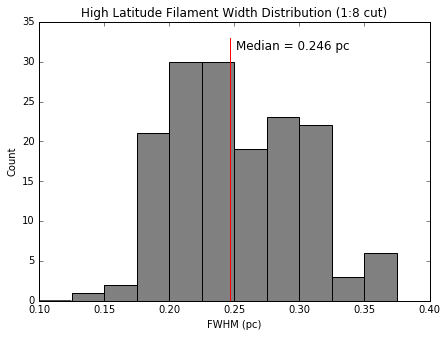

In [116]:
fig3_1 = plt.figure(figsize=(7, 5))
ax1 = fig3_1.add_subplot(111)

bins = np.linspace(.1, .40, 13)

n_1_8, _, _ = ax1.hist(fwhm_list_1_8, bins, color='grey')
ax1.plot([np.median(fwhm_list_1_8), np.median(fwhm_list_1_8)], [0, max(n_1_8) * 1.1], color='red')
ax1.text(np.median(fwhm_list_1_8) + .005, max(n_1_8) * 1.05,
         'Median = {0:05.3f} pc'.format(np.median(fwhm_list_1_8)), fontsize=12)

ax1.set_xlim(0.1, .4)
ax1.set_title('High Latitude Filament Width Distribution (1:8 cut)')
ax1.set_xlabel('FWHM (pc)')
ax1.set_ylabel('Count')

fig3_1.show()
fig3_1.savefig('../width_dist_batch_3_1_8.pdf')

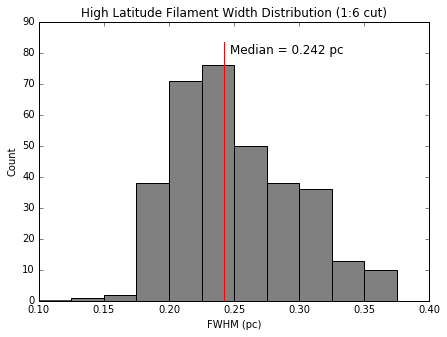

In [117]:
fig3_2 = plt.figure(figsize=(7, 5))
ax2 = fig3_2.add_subplot(111)

bins = np.linspace(.1, .40, 13)

n_1_6, _, _ = ax2.hist(fwhm_list_1_6, bins, color='grey')
ax2.plot([np.median(fwhm_list_1_6), np.median(fwhm_list_1_6)], [0, max(n_1_6) * 1.1], color='red')
ax2.text(np.median(fwhm_list_1_6) + .005, max(n_1_6) * 1.05,
         'Median = {0:05.3f} pc'.format(np.median(fwhm_list_1_6)), fontsize=12)

ax2.set_xlim(0.1, .4)
ax2.set_title('High Latitude Filament Width Distribution (1:6 cut)')
ax2.set_xlabel('FWHM (pc)')
ax2.set_ylabel('Count')

fig3_2.show()
fig3_2.savefig('../width_dist_batch_3_1_6.pdf')

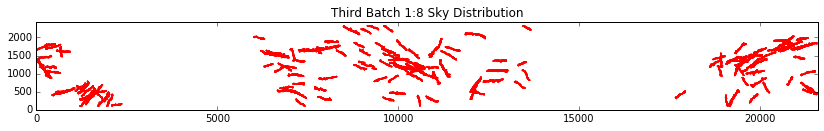

In [126]:
fig4 = tree_vis.vis_trees_sky_dist(third_batch_1_8, 'Third Batch 1:8', return_fig=True)
fig4.show()
fig4.savefig('../sky_dist_third_batch_1_8.pdf')

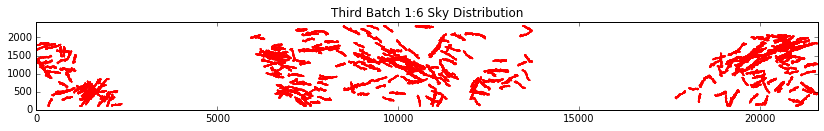

In [127]:
fig4_1 = tree_vis.vis_trees_sky_dist(third_batch_1_6, 'Third Batch 1:6', return_fig=True)
fig4_1.show()
fig4_1.savefig('../sky_dist_third_batch_1_6.pdf')

In [ ]:
'134_23_0' name & append ra&dec / l&b header keyward for roundess! EXCLUDE TOUCHING EDGES
figure out whats going on with blobs

put figures in dropbox